<a href="https://colab.research.google.com/github/wanjihiasimon/wanjihiasimon/blob/main/brain%20tumor%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import median_filter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import VotingClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive', timeout_ms=300000)


Mounted at /content/drive


In [ ]:
# Step 1: Load data
training_dir = "/content/drive/MyDrive/progress.dataset/Training"
testing_dir = "/content/drive/MyDrive/progress.dataset/Testing"
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
# Helper function to load images
def load_images(directory):
    images = []
    labels = []
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            try:
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
                if image is None:
                    continue  # Skip non-image files
                image = cv2.resize(image, (64, 64))  # Resize to 64x64
                image = median_filter(image, size=3)  # Noise removal
                images.append(image)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
    return np.array(images), np.array(labels)

# Load training and testing data
train_images, train_labels = load_images(training_dir)
test_images, test_labels = load_images(testing_dir)


In [ ]:
from skimage.segmentation import watershed

In [ ]:
# Load training data
training_dir = "/content/drive/MyDrive/progress.dataset/Training"
training_images, training_labels = load_images(training_dir)

# Function to segment images
def segment_image(image):
    try:
        # Apply Canny edge detector
        edges = cv2.Canny(image, 100, 200)

        # Apply distance transform
        dist_transform = cv2.distanceTransform(edges, cv2.DIST_L2, 5)

        # Normalize the distance transform
        _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)

        # Find sure background area
        sure_bg = cv2.dilate(edges, np.ones((3, 3), np.uint8), iterations=3)
        sure_bg = np.uint8(sure_bg)

        # Find unknown region
        unknown = cv2.subtract(sure_bg, sure_fg)

        # Apply watershed algorithm
        markers = cv2.connectedComponents(sure_fg)[1]
        markers = markers + 1
        markers[unknown == 255] = 0
        segmented = watershed(-dist_transform, markers, mask=edges)

        return segmented
    except Exception as e:
        print(f"Error segmenting image: {e}")
        return None

# Segment all images in the training set
def segment_all_images(images):
    segmented_images = []
    for image in images:
        segmented_image = segment_image(image)
        if segmented_image is not None:
            segmented_images.append(segmented_image)
    return segmented_images

# Segment all training images
segmented_training_images = segment_all_images(training_images)


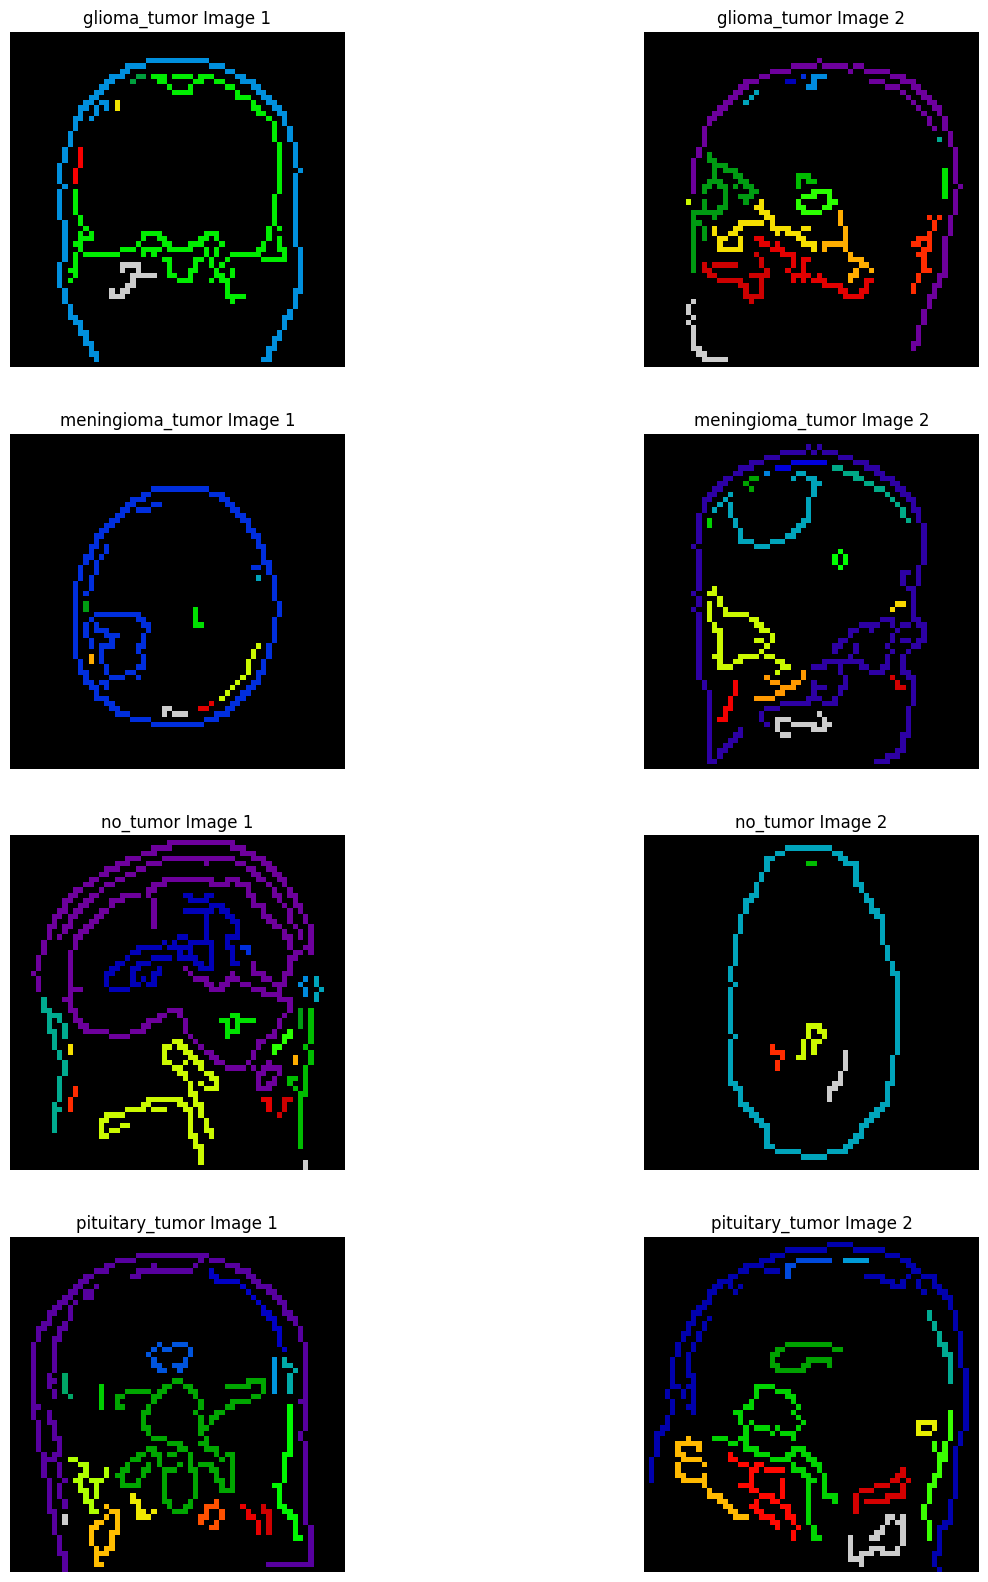

In [ ]:
import matplotlib.pyplot as plt

def visualize_two_images_per_category(segmented_images, labels):
    categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    num_images_per_category = 2
    images_to_display = []
    titles = []

    for category_index, category in enumerate(categories):
        # Filter images for the current category
        category_images = [img for img, label in zip(segmented_images, labels) if label == category_index]

        # Select up to two images for the category
        selected_images = category_images[:num_images_per_category]
        images_to_display.extend(selected_images)

        # Create titles for the selected images
        for i in range(len(selected_images)):
            titles.append(f"{category} Image {i+1}")

    # Visualize the selected images
    num_images = len(images_to_display)
    num_cols = 2
    num_rows = (num_images + num_cols - 1) // num_cols  # Compute number of rows needed
    plt.figure(figsize=(15, num_rows * 5))
    for i, (img, title) in enumerate(zip(images_to_display, titles)):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img, cmap='nipy_spectral')  # 'nipy_spectral' provides distinct colors
        plt.title(title)
        plt.axis('off')
    plt.show()

# Visualize two segmented images from each category
visualize_two_images_per_category(segmented_training_images, training_labels)


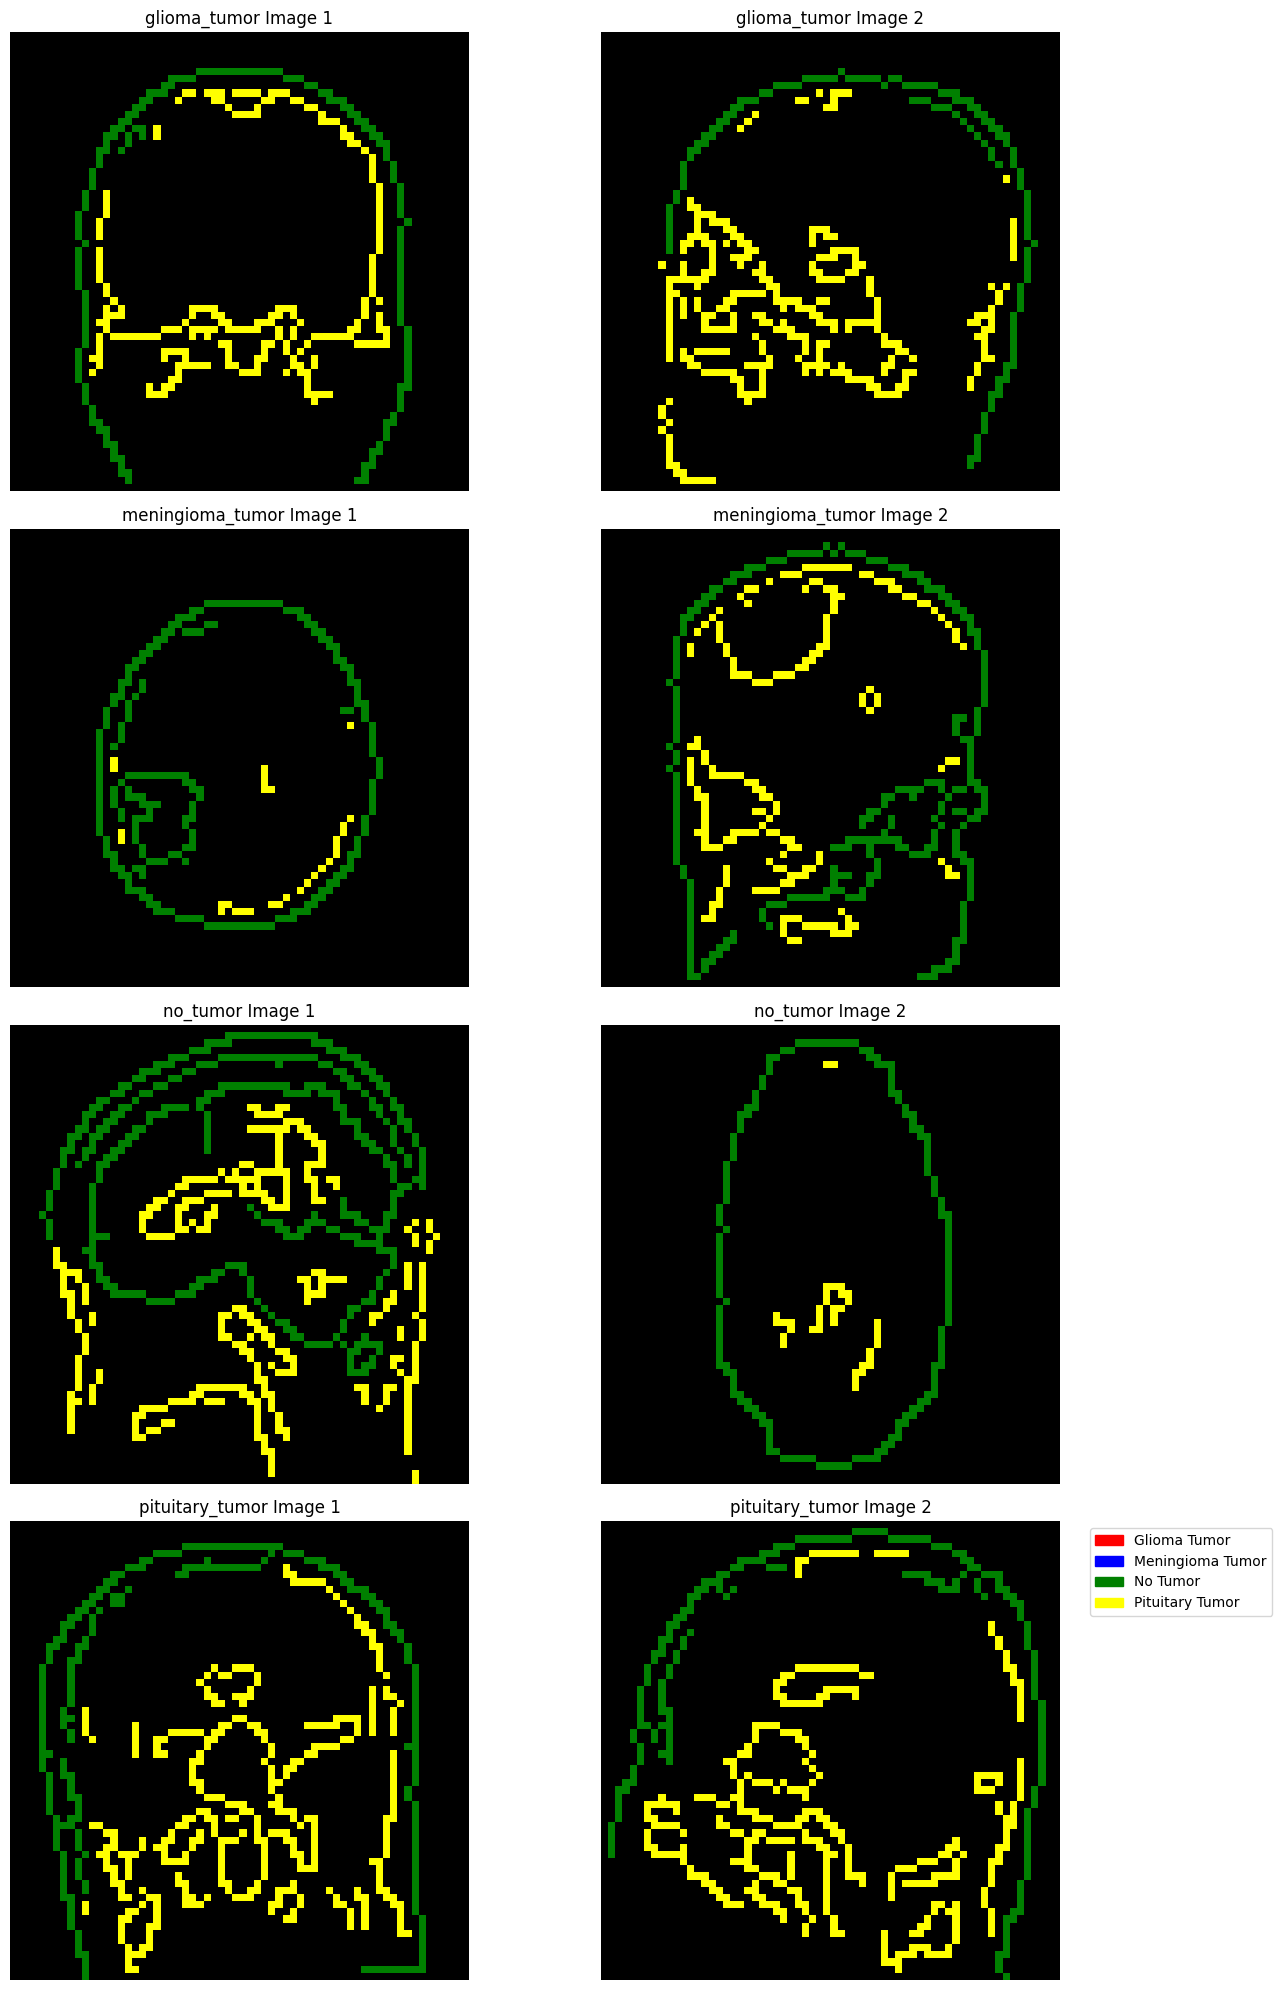

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Define your categories
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

def create_custom_colormap():
    # Define colors for each label
    colors = {
        0: 'black',  # Background
        1: 'red',    # Glioma Tumor
        2: 'blue',   # Meningioma Tumor
        3: 'green',  # No Tumor
        4: 'yellow'  # Pituitary Tumor
    }
    cmap = mcolors.ListedColormap([colors[i] for i in range(len(colors))])
    return cmap

def visualize_two_images_per_category_with_legend(segmented_images, labels):
    num_images_per_category = 2
    images_to_display = []
    titles = []

    for category_index, category in enumerate(categories):
        # Filter images for the current category
        category_images = [img for img, label in zip(segmented_images, labels) if label == category_index]

        # Select up to two images for the category
        selected_images = category_images[:num_images_per_category]
        images_to_display.extend(selected_images)

        # Create titles for the selected images
        for i in range(len(selected_images)):
            titles.append(f"{category} Image {i+1}")

    # Visualize the selected images
    cmap = create_custom_colormap()
    num_images = len(images_to_display)
    num_cols = 2
    num_rows = (num_images + num_cols - 1) // num_cols  # Compute number of rows needed
    plt.figure(figsize=(15, num_rows * 5))
    for i, (img, title) in enumerate(zip(images_to_display, titles)):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img, cmap=cmap, vmin=0, vmax=len(categories) - 1)  # Ensure correct colormap range
        plt.title(title)
        plt.axis('off')

    # Create a legend for the categories
    patches = [
        mpatches.Patch(color=cmap(1), label='Glioma Tumor'),
        mpatches.Patch(color=cmap(2), label='Meningioma Tumor'),
        mpatches.Patch(color=cmap(3), label='No Tumor'),
        mpatches.Patch(color=cmap(4), label='Pituitary Tumor')
    ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Assume `segmented_training_images` and `training_labels` are already defined
visualize_two_images_per_category_with_legend(segmented_training_images, training_labels)


In [ ]:
print(f'Number of training images: {len(train_images)}')
print(f'Number of testing images: {len(test_images)}')

In [ ]:
import os

# Function to count images in each category
def count_images(directory, categories):
    category_counts = {}

    for category in categories:
        category_path = os.path.join(directory, category)
        category_count = len(os.listdir(category_path))
        category_counts[category] = category_count

    return category_counts

# Count images in training dataset
train_category_counts = count_images(training_dir, categories)
print("Training Dataset:")
for category, count in train_category_counts.items():
    print(f"{category}: {count} images")
print("Total images in training dataset:", sum(train_category_counts.values()))

# Count images in testing dataset
test_category_counts = count_images(testing_dir, categories)
print("\nTesting Dataset:")
for category, count in test_category_counts.items():
    print(f"{category}: {count} images")
print("Total images in testing dataset:", sum(test_category_counts.values()))


Training Dataset:
glioma_tumor: 827 images
meningioma_tumor: 822 images
no_tumor: 396 images
pituitary_tumor: 827 images
Total images in training dataset: 2872

Testing Dataset:
glioma_tumor: 1 images
meningioma_tumor: 1 images
no_tumor: 24 images
pituitary_tumor: 75 images
Total images in testing dataset: 101


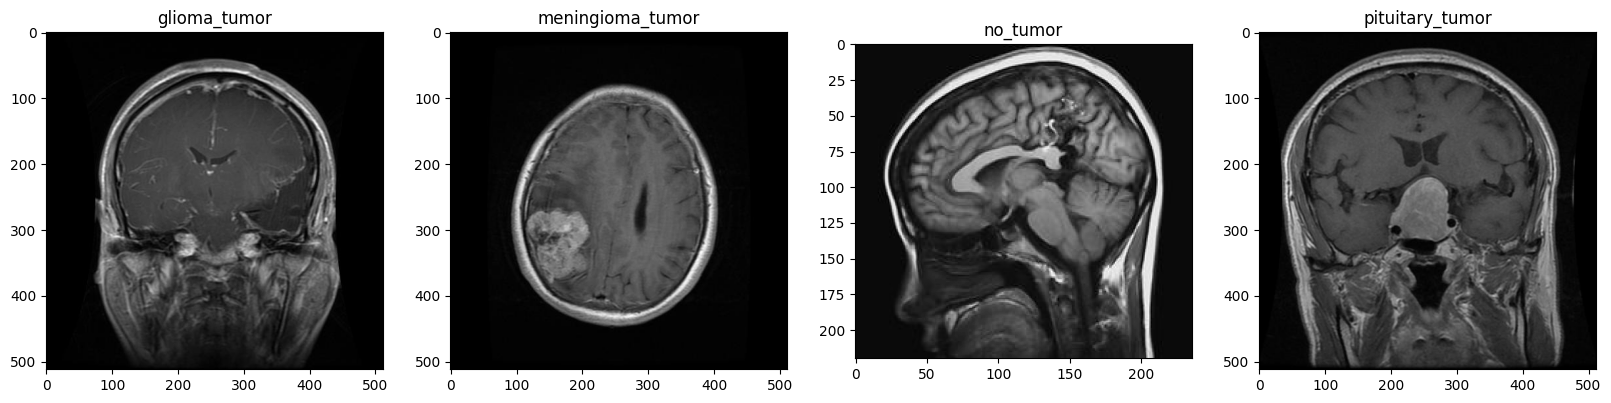

In [ ]:
# Step 3: Visualize one image in each category in train directory
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, category in enumerate(categories):
    path = os.path.join(training_dir, category)
    img_name = os.listdir(path)[0]
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(category)
plt.show()

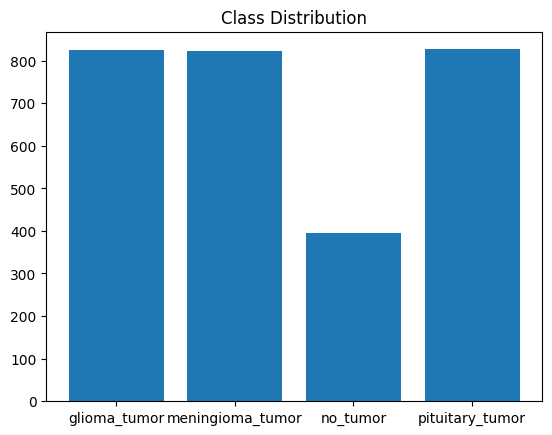

In [ ]:
# Step 4: Visualize class distribution
unique, counts = np.unique(train_labels, return_counts=True)
plt.bar(categories, counts)
plt.title('Class Distribution')
plt.show()

In [ ]:
# Step 5: Preprocess data (normalize and augment)
train_images = train_images / 255.0
test_images = test_images / 255.0


In [ ]:
# Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [ ]:
# Step 6: Split data
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
# Reshape for CNN
X_train = X_train.reshape(-1, 64, 64, 1)
X_val = X_val.reshape(-1, 64, 64, 1)
test_images = test_images.reshape(-1, 64, 64, 1)


In [ ]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)
y_test_cat = to_categorical(test_labels, num_classes=4)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Step 7: Train individual models

# SVM
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train.reshape(-1, 64*64), y_train)

SVC(kernel='linear', probability=True)

In [ ]:
y_pred_svm = svm_clf.predict(X_val.reshape(-1, 64*64))
print("SVM Classification Report")
print(classification_report(y_val, y_pred_svm))


svm_accuracy = accuracy_score(y_val, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy}")


SVM Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       179
           1       0.80      0.69      0.74       169
           2       0.78      0.70      0.74        70
           3       0.90      0.98      0.94       156

    accuracy                           0.83       574
   macro avg       0.82      0.81      0.81       574
weighted avg       0.82      0.83      0.82       574

SVM Accuracy: 0.8257839721254355


In [ ]:
# Logistic Regression
log_reg_clf = LogisticRegression(max_iter=1000)
log_reg_clf.fit(X_train.reshape(-1, 64*64), y_train)



LogisticRegression(max_iter=1000)

In [ ]:
y_pred_log_reg = log_reg_clf.predict(X_val.reshape(-1, 64*64))
print("Logistic Regression Classification Report")
print(classification_report(y_val, y_pred_log_reg))


# Logistic Regression Predictions
log_reg_accuracy = accuracy_score(y_val, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")



Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       179
           1       0.79      0.66      0.72       169
           2       0.78      0.71      0.75        70
           3       0.86      0.97      0.91       156

    accuracy                           0.81       574
   macro avg       0.80      0.80      0.80       574
weighted avg       0.81      0.81      0.81       574

Logistic Regression Accuracy: 0.8101045296167247


In [ ]:
# CNN
cnn_clf = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
cnn_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_clf.fit(datagen.flow(X_train, y_train_cat, batch_size=32), validation_data=(X_val, y_val_cat), epochs=10)


Epoch 1/10
72/72 [==============================] - 4s 25ms/step - loss: 1.3625 - accuracy: 0.2975 - val_loss: 1.9129 - val_accuracy: 0.2944
Epoch 2/10
72/72 [==============================] - 2s 23ms/step - loss: 1.3545 - accuracy: 0.2901 - val_loss: 1.7592 - val_accuracy: 0.3955
Epoch 3/10
72/72 [==============================] - 2s 32ms/step - loss: 1.3561 - accuracy: 0.2988 - val_loss: 1.8632 - val_accuracy: 0.2718
Epoch 4/10
72/72 [==============================] - 3s 40ms/step - loss: 1.3536 - accuracy: 0.2927 - val_loss: 1.6436 - val_accuracy: 0.3728
Epoch 5/10
72/72 [==============================] - 2s 23ms/step - loss: 1.3557 - accuracy: 0.2936 - val_loss: 1.6955 - val_accuracy: 0.2944
Epoch 6/10
72/72 [==============================] - 2s 23ms/step - loss: 1.3532 - accuracy: 0.2853 - val_loss: 1.7167 - val_accuracy: 0.3049
Epoch 7/10
72/72 [==============================] - 2s 22ms/step - loss: 1.3524 - accuracy: 0.2857 - val_loss: 1.6020 - val_accuracy: 0.2875
Epoch 8/10
72

In [ ]:
y_pred_cnn = cnn_clf.predict(X_val)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
print("CNN Classification Report")
print(classification_report(y_val, y_pred_cnn))

cnn_accuracy = accuracy_score(y_val, y_pred_cnn)
print(f"CNN Accuracy: {cnn_accuracy}")



18/18 [==============================] - 0s 2ms/step
CNN Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.35      0.60      0.44       169
           2       0.00      0.00      0.00        70
           3       0.47      0.85      0.60       156

    accuracy                           0.41       574
   macro avg       0.20      0.36      0.26       574
weighted avg       0.23      0.41      0.29       574

CNN Accuracy: 0.4076655052264808


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, to_categorical(y, num_classes=4), epochs=10, verbose=0)
        return self

    def predict(self, X):
        predictions = self.model.predict(X)
        return np.argmax(predictions, axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)

cnn_wrapper = KerasClassifierWrapper(model=cnn_clf)

ensemble_clf = VotingClassifier(estimators=[
    ('svm', svm_clf),
    ('cnn', cnn_wrapper)
], voting='soft')


In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble_clf = VotingClassifier(estimators=[
    ('svm', svm_clf),
    ('cnn', cnn_wrapper)
], voting='hard')


In [ ]:
# Reshape data for the ensemble classifier
X_train_reshaped = X_train.reshape(-1, 64*64)
X_val_reshaped = X_val.reshape(-1, 64*64)


In [ ]:


ensemble_clf.fit(X_train_reshaped, y_train)


y_pred_ensemble = ensemble_clf.predict(X_val_reshaped)
print("Ensemble Model Classification Report")
print(classification_report(y_val, y_pred_ensemble))

In [ ]:
# Calculate the sum of the accuracies
total_accuracy = log_reg_accuracy + cnn_accuracy + svm_accuracy

# Normalize the accuracies to get weights
weights = {
    'log_reg': log_reg_accuracy / total_accuracy,
    'cnn': cnn_accuracy / total_accuracy,
    'svm': svm_accuracy / total_accuracy
}

print(f"Weights: {weights}")


Weights: {'log_reg': 0.39641943734015345, 'cnn': 0.19948849104859334, 'svm': 0.4040920716112532}


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# One-hot encode the predictions for Logistic Regression and SVM
y_pred_log_reg_onehot = np.zeros((y_pred_log_reg.size, np.max(y_val)+1))
y_pred_log_reg_onehot[np.arange(y_pred_log_reg.size), y_pred_log_reg] = 1

y_pred_svm_onehot = np.zeros((y_pred_svm.size, np.max(y_val)+1))
y_pred_svm_onehot[np.arange(y_pred_svm.size), y_pred_svm] = 1


In [ ]:
# Combine the predictions using the weighted average
y_pred_combined = (weights['log_reg'] * y_pred_log_reg_onehot +
                   weights['cnn'] * cnn_clf.predict(X_val) +
                   weights['svm'] * y_pred_svm_onehot)


18/18 [==============================] - 0s 5ms/step


In [ ]:
# Get the final predictions by taking the argmax of the combined predictions
y_pred_ensemble = np.argmax(y_pred_combined, axis=1)


In [ ]:
# Evaluate the ensemble predictions
print("Ensemble Classification Report")
print(classification_report(y_val, y_pred_ensemble))

Ensemble Classification Report
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       179
           1       0.77      0.72      0.75       169
           2       0.80      0.67      0.73        70
           3       0.88      0.98      0.93       156

    accuracy                           0.82       574
   macro avg       0.82      0.80      0.81       574
weighted avg       0.82      0.82      0.82       574



In [ ]:
import os
import joblib
import json
# Specify the directory where you want to save the files
save_dir = "/content/drive/MyDrive/progress.dataset"


# Save the models and weights with full paths
joblib.dump(log_reg_clf, os.path.join(save_dir, 'log_reg_model.pkl'))
joblib.dump(svm_clf, os.path.join(save_dir, 'svm_model.pkl'))
cnn_clf.save(os.path.join(save_dir, 'cnn_model.h5'))

with open(os.path.join(save_dir, 'ensemble_weights.json'), 'w') as f:
    json.dump(weights, f)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
